<a href="https://colab.research.google.com/github/djdumpling/SBA-files/blob/main/CCAR_SBA_time_series_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing, Database

In [ ]:
pip install matplotlib pymysql pandas SQLAlchemy statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.1 MB/s eta 0:00:00


In [ ]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np

from google.colab import files

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter
import textwrap
import seaborn as sns

import statistics
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [ ]:
db =  {
    "hostname":"sbaloandata.c1y4g4kqkbn1.us-east-1.rds.amazonaws.com",
    "port":3306,
    "username": "sbadev1",
    "password": "SbaDevATL1!",
    "database": "sbaloan"
    }

connection_string = f"mysql+pymysql://{db['username']}:{db['password']}@{db['hostname']}:{db['port']}/{db['database']}"
engine = create_engine(connection_string)

In [ ]:
def res_df_input(origination_date, origination_date_range, engine, MinGrossApproval = None, MaxGrossApproval = None, MinimumTermInMonths = None, NaicsCode = None, BorrState = None, BorrZip = None, BorrCity = None, BankName = None, ):
    origination_date = pd.to_datetime(origination_date)
    end_date = origination_date + DateOffset(months=origination_date_range) - DateOffset(days=1)

    start_date_str = origination_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')

    query = f"""
        SELECT *
        FROM sba_loan_7a
        WHERE ApprovalDate BETWEEN '{start_date_str}' AND '{end_date_str}'
    """

    conditions = []

    if MinGrossApproval is not None:
        conditions.append(f"GrossApproval >= {MinGrossApproval}")

    if MaxGrossApproval is not None:
        conditions.append(f"GrossApproval <= {MaxGrossApproval}")

    if MinimumTermInMonths is not None:
        conditions.append(f"TermInMonths >= '{MinimumTermInMonths}'")

    # to get the sector on the buisness
    # can change easily for the full NaicsCode
    if NaicsCode is not None:
        conditions.append(f"SUBSTRING(NaicsCode, 1, 2) = '{NaicsCode[:2]}'")

    if BorrState is not None:
        conditions.append(f"BorrState = '{BorrState}'")

    if BorrZip is not None:
        conditions.append(f"BorrZip = '{BorrZip}'")

    if BorrCity is not None:
        conditions.append(f"BorrCity = '{BorrCity}'")

    if BankName is not None:
        conditions.append(f"BankName = '{BankName}'")

    if conditions:
        query += " AND " + " AND ".join(conditions)

    query += " ORDER BY ApprovalDate"

    res_df = pd.read_sql_query(query, engine)

    return res_df

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

# change the parameters accordingly
origination_date = '1990-10-01'
origination_date_range = 408   # range for the origination date
MinGrossApproval = None
MaxGrossApproval = None
MinimumTermInMonths = None   # minimum term of the loan
NaicsCode = None             #sector of NaicsCode (need string, not number)
BorrState = None
BorrZip = None
BorrCity = None
BankName = None

res_df = res_df_input(origination_date,
                      origination_date_range,
                      engine,
                      MinGrossApproval = MinGrossApproval,
                      MaxGrossApproval = MaxGrossApproval,
                      MinimumTermInMonths = MinimumTermInMonths,
                      NaicsCode = NaicsCode,
                      BorrState = BorrState,
                      BorrZip = BorrZip,
                      BorrCity = BorrCity,
                      BankName = BankName)
res_df

,LoanId,Program,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,BankName,BankFDICNumber,BankNCUANumber,BankStreet,BankCity,BankState,BankZip,GrossApproval,SBAGuaranteedApproval,ApprovalDate,ApprovalFiscalYear,FirstDisbursementDate,DeliveryMethod,Subprogram,InitialInterestRate,FixedOrVariableInterestInd,TermInMonths,NaicsCode,NaicsDescription,FranchiseCode,FranchiseName,ProjectCounty,ProjectState,SBADistrictOffice,CongressionalDistrict,BusinessType,BusinessAge,LoanStatus,PaidInFullDate,ChargeOffDate,GrossChargeOffAmount,RevolverStatus,JobsSupported,SoldSecMrktInd
0,f64a607c-180e-4cf0-8a67-32a42059ea06,7A,TECHNIGRAPHICS,1880 PARKWAY BLVD.,WEST VALLEY,UT,84119,BMO Bank National Association,16571.0,NaN,320 S Canal St,Chicago,IL,60606,839200.0,671360.0,1990-10-01,1991,1990-10-31,PLP,Guaranty,0.00,,120,323121,Tradebinding and Related Work,None,,SALT LAKE,UT,UTAH DISTRICT OFFICE,02,PARTNERSHIP,,PIF,2005-07-31,None,0.0,0,0,Y
1,f5033e4e-35e8-49ec-8d07-03462cd60bd4,7A,REHABILITATION ADVISORS INC,445 WYMORE ROAD STE 220,WINTER PARK,FL,32789,"TD Bank, National Association",18409.0,NaN,2035 Limestone Rd,WILMINGTON,DE,19808,200000.0,170000.0,1990-10-01,1991,1991-01-31,OTH 7A,Guaranty,0.00,,60,624310,Vocational Rehabilitation Services,None,,ORANGE,FL,NORTH FLORIDA DISTRICT OFFICE,07,CORPORATION,,PIF,2005-07-31,None,0.0,0,0,
2,dbc26869-0981-49be-bb74-7021877ed905,7A,GREEN VALLEY GROCERY/CRAWFORD,3915 W. TWAIN,LAS VEGAS,NV,89103,"Wells Fargo Bank, National Association",3511.0,NaN,101 N Philips Ave,SIOUX FALLS,SD,57104,345000.0,258750.0,1990-10-01,1991,1990-10-31,PLP,Guaranty,0.00,,246,,,None,,CLARK,NV,NEVADA DISTRICT OFFICE,01,CORPORATION,,PIF,2005-07-31,None,0.0,0,0,N
3,dac354b6-721f-4f81-a84f-7463afee284f,7A,FOUR SEASONS PLANT CTR. INC.,222 S. POPE ST.,BRECKENRIDGE,MN,56520,BMO Bank National Association,16571.0,NaN,320 S Canal St,Chicago,IL,60606,98900.0,89010.0,1990-10-01,1991,1990-10-31,OTH 7A,Guaranty,0.00,,11,,,None,,WILKIN,MN,MINNESOTA DISTRICT OFFICE,07,CORPORATION,,PIF,2005-07-31,None,0.0,0,0,
4,c7b5804d-05a6-4d79-80bf-9e6f5bedab28,7A,Michael Davis,P O BOX 1457,FOND DU LAC,WI,54936,"U.S. Bank, National Association",6548.0,NaN,425 Walnut St,CINCINNATI,OH,45202,250000.0,200000.0,1990-10-01,1991,1990-10-31,PLP,Guaranty,0.00,,48,,,None,,FOND DU LAC,WI,MILWAUKEE,06,CORPORATION,,PIF,2005-07-31,None,0.0,0,0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1803628,a6f09f19-2311-4cd1-adb9-3d7d2e49d4af,7A,Saunders Construction LLC,18 UNION ST,READING,MA,01867,Rockland Trust Company,9712.0,NaN,288 Union St,ROCKLAND,MA,02370,75000.0,37500.0,2024-03-30,2024,None,SBA EXPRES,FA$TRK (Small Loan Express),9.50,V,120,238190,"Other Foundation, Structure, and Building Exte...",None,,MIDDLESEX,MA,MASSACHUSETTS DISTRICT OFFICE,06,CORPORATION,Existing or more than 2 years old,COMMIT,None,None,0.0,1,5,
1803629,a5e265c8-5d70-4588-ae25-1d061f156786,7A,OPEN RETAIL INC.,108 N ST ANDREWS PL,LOS ANGELES,CA,90004,BayFirst National Bank,34997.0,NaN,700 Central Avenue,Saint Petersburg,FL,33701,150000.0,127500.0,2024-03-30,2024,None,PLP,Guaranty,13.25,V,120,513210,Cable Networks,None,,LOS ANGELES,CA,LOS ANGELES DISTRICT OFFICE,28,CORPORATION,Existing or more than 2 years old,COMMIT,None,None,0.0,0,2,
1803630,b3c0fbe7-7d71-4b19-ae49-c2d83d4dee97,7A,MY DRYWALL LLC,9191 STATE ROUTE 305,GARRETTSVILLE,OH,44231,The Huntington National Bank,6560.0,NaN,17 S High St.,COLUMBUS,OH,43215,150000.0,75000.0,2024-03-30,2024,None,SBA EXPRES,FA$TRK (Small Loan Express),10.50,V,120,238310,Drywall and Insulation Contractors,None,,PORTAGE,OH,CLEVELAND DISTRICT OFFICE,13,CORPORATION,Existing or more than 2 years old,COMMIT,None,None,0.0,1,0,
1803631,b4640bb3-13c4-4f70-971a-195b2368dd4d,7A,Green Turf Owners Landscaping,418 STAHL AVE,NEW CASTLE,DE,19720,"TD Bank, National Association",18409.0,NaN,2035 Limestone Rd,WILMINGTON,DE,19808,25000.0,12500.0,2024-03-30,2024,None,SBA 

In [ ]:
res_df.drop(columns=['LoanId',
                     'Program',
                     'BorrStreet',
                     'BankNCUANumber',
                     'BankStreet',
                     'NaicsDescription',
                     'FranchiseCode',
                     'FranchiseName',
                     'CongressionalDistrict',
                     'SoldSecMrktInd'], inplace=True)

KeyError: "['LoanId', 'Program', 'BorrStreet', 'BankNCUANumber', 'BankStreet', 'NaicsDescription', 'FranchiseCode', 'FranchiseName', 'CongressionalDistrict', 'SoldSecMrktInd'] not found in axis"

In [ ]:
res_df['ApprovalDate'] = pd.to_datetime(res_df['ApprovalDate'])
res_df['Quarter'] = res_df['ApprovalDate'].dt.to_period('Q').astype(str).str.replace('Q', ' Q')
res_df['Month'] = res_df['ApprovalDate'].dt.to_period('M')

res_df

,BorrName,BorrCity,BorrState,BorrZip,BankName,BankFDICNumber,BankCity,BankState,BankZip,GrossApproval,SBAGuaranteedApproval,ApprovalDate,ApprovalFiscalYear,FirstDisbursementDate,DeliveryMethod,Subprogram,InitialInterestRate,FixedOrVariableInterestInd,TermInMonths,NaicsCode,ProjectCounty,ProjectState,SBADistrictOffice,BusinessType,BusinessAge,LoanStatus,PaidInFullDate,ChargeOffDate,GrossChargeOffAmount,RevolverStatus,JobsSupported,Quarter,MonthsToChargeOff,DefaultWithin5Years,FiveYearThreshold,Month
0,TECHNIGRAPHICS,WEST VALLEY,UT,84119,BMO Bank National Association,16571.0,Chicago,IL,60606,839200.0,671360.0,1990-10-01,1991,1990-10-31,PLP,Guaranty,0.00,,120,323121,SALT LAKE,UT,UTAH DISTRICT OFFICE,PARTNERSHIP,,PIF,2005-07-31,NaT,0.0,0,0,1990 Q4,NaN,0,1995-10-01,1990-10
1,REHABILITATION ADVISORS INC,WINTER PARK,FL,32789,"TD Bank, National Association",18409.0,WILMINGTON,DE,19808,200000.0,170000.0,1990-10-01,1991,1991-01-31,OTH 7A,Guaranty,0.00,,60,624310,ORANGE,FL,NORTH FLORIDA DISTRICT OFFICE,CORPORATION,,PIF,2005-07-31,NaT,0.0,0,0,1990 Q4,NaN,0,1995-10-01,1990-10
2,GREEN VALLEY GROCERY/CRAWFORD,LAS VEGAS,NV,89103,"Wells Fargo Bank, National Association",3511.0,SIOUX FALLS,SD,57104,345000.0,258750.0,1990-10-01,1991,1990-10-31,PLP,Guaranty,0.00,,246,,CLARK,NV,NEVADA DISTRICT OFFICE,CORPORATION,,PIF,2005-07-31,NaT,0.0,0,0,1990 Q4,NaN,0,1995-10-01,1990-10
3,FOUR SEASONS PLANT CTR. INC.,BRECKENRIDGE,MN,56520,BMO Bank National Association,16571.0,Chicago,IL,60606,98900.0,89010.0,1990-10-01,1991,1990-10-31,OTH 7A,Guaranty,0.00,,11,,WILKIN,MN,MINNESOTA DISTRICT OFFICE,CORPORATION,,PIF,2005-07-31,NaT,0.0,0,0,1990 Q4,NaN,0,1995-10-01,1990-10
4,Michael Davis,FOND DU LAC,WI,54936,"U.S. Bank, National Association",6548.0,CINCINNATI,OH,45202,250000.0,200000.0,1990-10-01,1991,1990-10-31,PLP,Guaranty,0.00,,48,,FOND DU LAC,WI,MILWAUKEE,CORPORATION,,PIF,2005-07-31,NaT,0.0,0,0,1990 Q4,NaN,0,1995-10-01,1990-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1803628,Saunders Construction LLC,READING,MA,01867,Rockland Trust Company,9712.0,ROCKLAND,MA,02370,75000.0,37500.0,2024-03-30,2024,None,SBA EXPRES,FA$TRK (Small Loan Express),9.50,V,120,238190,MIDDLESEX,MA,MASSACHUSETTS DISTRICT OFFICE,CORPORATION,Existing or more than 2 years old,COMMIT,None,NaT,0.0,1,5,2024 Q1,NaN,0,2029-03-30,2024-03
1803629,OPEN RETAIL INC.,LOS ANGELES,CA,90004,BayFirst National Bank,34997.0,Saint Petersburg,FL,33701,150000.0,127500.0,2024-03-30,2024,None,PLP,Guaranty,13.25,V,120,513210,LOS ANGELES,CA,LOS ANGELES DISTRICT OFFICE,CORPORATION,Existing or more than 2 years old,COMMIT,None,NaT,0.0,0,2,2024 Q1,NaN,0,2029-03-30,2024-03
1803630,MY DRYWALL LLC,GARRETTSVILLE,OH,44231,The Huntington National Bank,6560.0,COLUMBUS,OH,43215,150000.0,75000.0,2024-03-30,2024,None,SBA EXPRES,FA$TRK (Small Loan Express),10.50,V,120,238310,PORTAGE,OH,CLEVELAND DISTRICT OFFICE,CORPORATION,Existing or more than 2 years old,COMMIT,None,NaT,0.0,1,0,2024 Q1,NaN,0,2029-03-30,2024-03
1803631,Green Turf Owners Landscaping,NEW CASTLE,DE,19720,"TD Bank, National Association",18409.0,WILMINGTON,DE,19808,25000.0,12500.0,2024-03-30,2024,None,SBA EXPRES,FA$TRK (Small Loan Express),12.30,V,120,541320,NEW CASTLE,DE,DELAWARE DISTRICT OFFICE,CORPORATION,Existing or more than 2 years old,COMMIT,None,NaT,0.0,1,0,2024 Q1,NaN,0,2029-03-30,2024-03


In [ ]:
res_df['ChargeOffDate'] = pd.to_datetime(res_df['ChargeOffDate'])

res_df['FiveYearThreshold'] = res_df['ApprovalDate'] + pd.DateOffset(months=60)
res_df['DefaultWithin5Years'] = (res_df['LoanStatus'] == 'CHGOFF') & (res_df['ChargeOffDate'] <= res_df['FiveYearThreshold'])
res_df['DefaultWithin5Years'] = res_df['DefaultWithin5Years'].astype(int)

default_percentage = res_df.groupby('Month')['DefaultWithin5Years'].mean() * 100

In [ ]:
default_percentage_df = default_percentage.reset_index()
default_percentage_df.columns = ['Quarter', 'DefaultPercentage']
default_percentage_df.to_csv('default_percentage_month.csv', index=False)

files.download('default_percentage_month.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Definitions and Visualization (SBA)

In [ ]:
# change the parameters accordingly
origination_date = '2002-01-01'
origination_date_range = 144   # range for the origination date
MinGrossApproval = None
MaxGrossApproval = None
MinimumTermInMonths = None   # minimum term of the loan
NaicsCode = None             #sector of NaicsCode (need string, not number)
BorrState = None
BorrZip = None
BorrCity = None
BankName = None

res_df = res_df_input(origination_date,
                      origination_date_range,
                      engine,
                      MinGrossApproval = MinGrossApproval,
                      MaxGrossApproval = MaxGrossApproval,
                      MinimumTermInMonths = MinimumTermInMonths,
                      NaicsCode = NaicsCode,
                      BorrState = BorrState,
                      BorrZip = BorrZip,
                      BorrCity = BorrCity,
                      BankName = BankName)

res_df.drop(columns=['LoanId',
                     'Program',
                     'BorrStreet',
                     'BankNCUANumber',
                     'BankStreet',
                     'NaicsDescription',
                     'FranchiseCode',
                     'FranchiseName',
                     'CongressionalDistrict',
                     'SoldSecMrktInd'], inplace=True)

res_df

,BorrName,BorrCity,BorrState,BorrZip,BankName,BankFDICNumber,BankCity,BankState,BankZip,GrossApproval,...,ProjectState,SBADistrictOffice,BusinessType,BusinessAge,LoanStatus,PaidInFullDate,ChargeOffDate,GrossChargeOffAmount,RevolverStatus,JobsSupported
0,MOUNTAIN TOP TRAILER SALES,EAST ANDOVER,NH,03231,"Citizens Bank, National Association",57957.0,PROVIDENCE,RI,02903,35000.0,...,NH,NEW HAMPSHIRE DISTRICT OFFICE,INDIVIDUAL,,PIF,2010-07-31,None,0.0,1,2
1,CAFE ETC INC,WHEATON,IL,60187,Byline Bank,20624.0,CHICAGO,IL,60601,66000.0,...,IL,ILLINOIS DISTRICT OFFICE,CORPORATION,,PIF,2005-05-31,None,0.0,0,0
2,QUALITY TIME CHILD CARE,SPRINGFIELD,MA,01118,Berkshire Bank,23621.0,PITTSFIELD,MA,01201,40000.0,...,MA,SPRINGFIELD BRANCH OFFICE,INDIVIDUAL,,PIF,2005-11-30,None,0.0,0,0
3,SUPERIOR STAIRS INC.,BEND,OR,97702,"Bank of America, National Association",3510.0,CHARLOTTE,NC,28202,10000.0,...,OR,PORTLAND DISTRICT OFFICE,CORPORATION,,PIF,2005-05-31,None,0.0,1,2
4,PERFORMANCE TECHNOLOGY ASSOCIA,DEVEREUX,MA,01923,"Bank of America, National Association",3510.0,CHARLOTTE,NC,28202,472000.0,...,MA,MASSACHUSETTS DISTRICT OFFICE,CORPORATION,,PIF,2005-05-31,None,0.0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795321,Foothills Family Dental PA,DUNCAN,SC,29334,Live Oak Banking Company,58665.0,WILMINGTON,NC,28403,854800.0,...,SC,SOUTH CAROLINA DISTRICT OFFICE,CORPORATION,,PIF,2018-08-31,None,0.0,0,9
795322,STEPNEY BROTHERS AUTO BODY INC,SAINT LOUIS,MO,63115,"U.S. Bank, National Association",6548.0,CINCINNATI,OH,45202,30000.0,...,MO,ST. LOUIS DISTRICT OFFICE,CORPORATION,,PIF,2020-12-31,None,0.0,1,10
795323,UP At City View LLC,CHARLOTTE,NC,28212,Pinnacle Bank,35583.0,NASHVILLE,TN,37201,371000.0,...,NC,NORTH CAROLINA DISTRICT OFFICE,CORPORATION,,EXEMPT,None,None,0.0,0,10
795324,Mataji Krupa Inc,indianapolis,IN,46113,The Huntington National Bank,6560.0,COLUMBUS,OH,43215,30000.0,...,IN,INDIANA DISTRICT OFFICE,CORPORATION,,PIF,2019-03-31,None,0.0,1,0


In [ ]:
res_df['ApprovalDate'] = pd.to_datetime(res_df['ApprovalDate'])
res_df['Quarter'] = res_df['ApprovalDate'].dt.to_period('Q').astype(str)

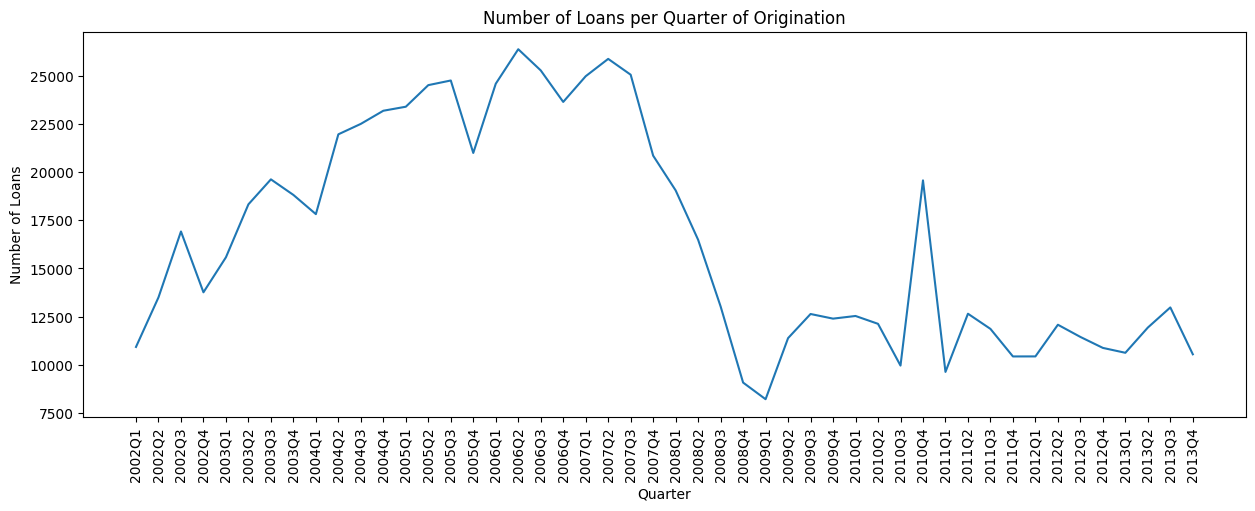

In [ ]:
quarterly_loans_count = res_df.groupby('Quarter').size().reset_index(name='LoanCount')
plt.figure(figsize=(15, 5))
sns.lineplot(data=quarterly_loans_count, x='Quarter', y='LoanCount')
plt.xticks(rotation=90)
plt.xlabel('Quarter')
plt.ylabel('Number of Loans')
plt.title('Number of Loans per Quarter of Origination')
plt.show()

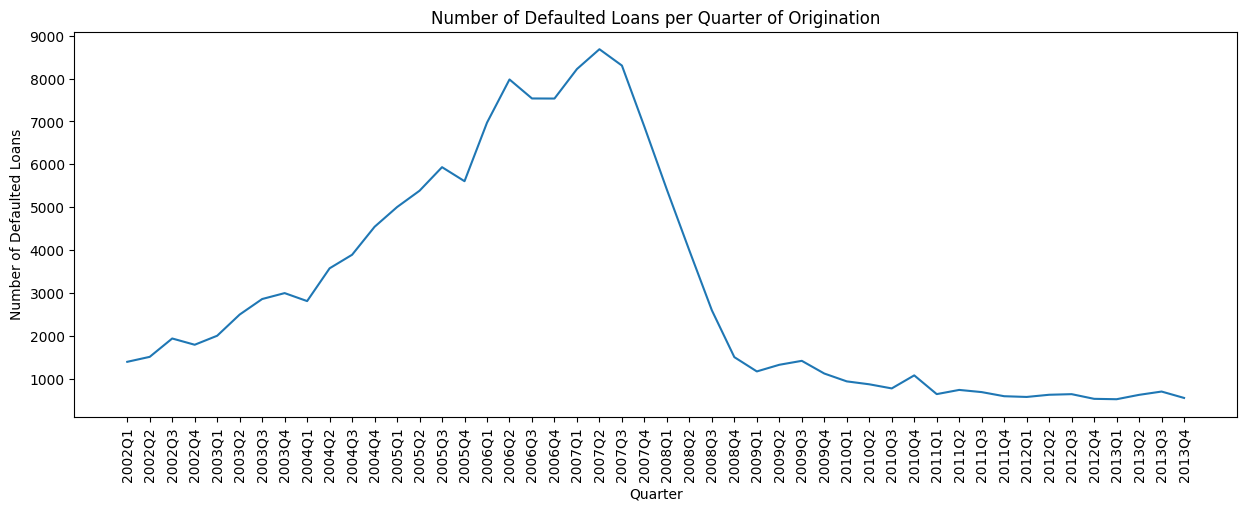

In [ ]:
res_df_defaulted = res_df[res_df['LoanStatus'] == 'CHGOFF']

quarterly_loans_count = res_df_defaulted.groupby('Quarter').size().reset_index(name='LoanCount')
plt.figure(figsize=(15, 5))
sns.lineplot(data=quarterly_loans_count, x='Quarter', y='LoanCount')
plt.xticks(rotation=90)
plt.xlabel('Quarter')
plt.ylabel('Number of Defaulted Loans')
plt.title('Number of Defaulted Loans per Quarter of Origination')
plt.show()

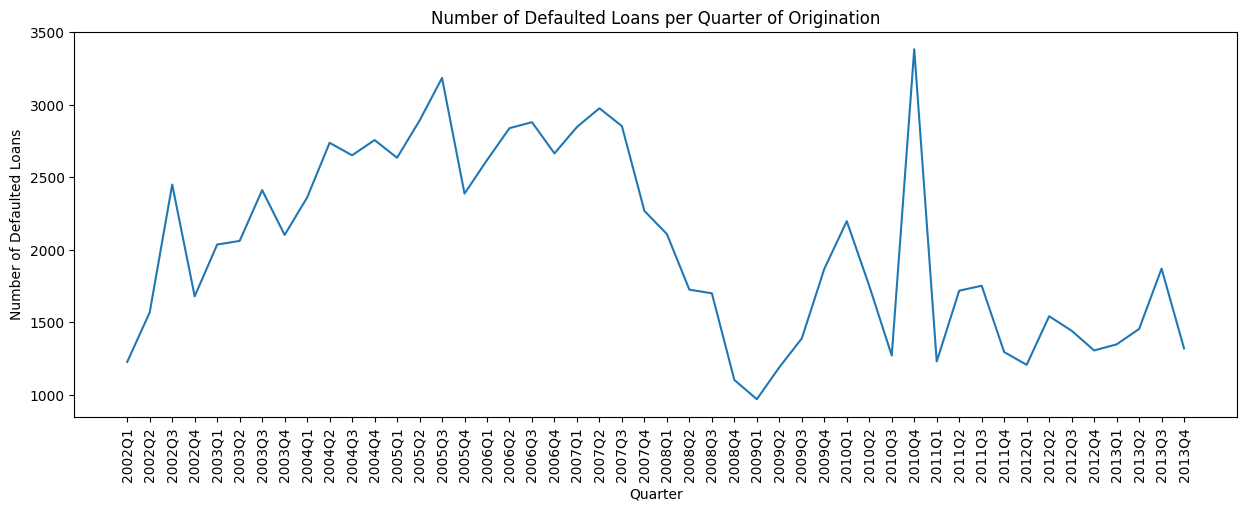

In [ ]:
res_df_defaulted = res_df[res_df['LoanStatus'] == 'CANCLD']

quarterly_loans_count = res_df_defaulted.groupby('Quarter').size().reset_index(name='LoanCount')
plt.figure(figsize=(15, 5))
sns.lineplot(data=quarterly_loans_count, x='Quarter', y='LoanCount')
plt.xticks(rotation=90)
plt.xlabel('Quarter')
plt.ylabel('Number of Canceled Loans')
plt.title('Number of Canceled Loans per Quarter of Origination')
plt.show()

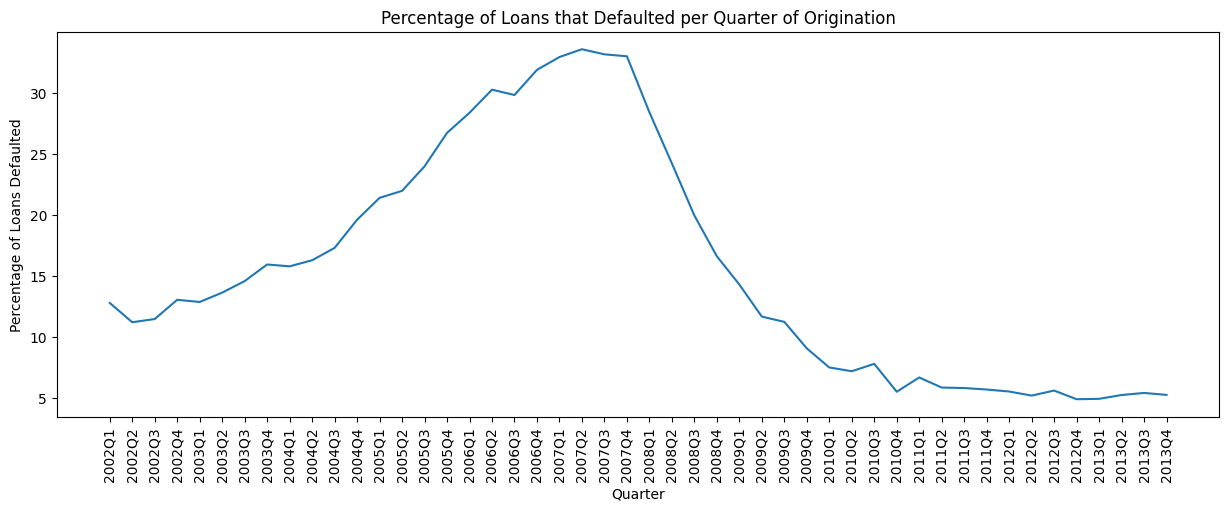

In [ ]:
total_loans_count = res_df.groupby('Quarter').size().reset_index(name='TotalLoanCount')
defaulted_loans_count = res_df[res_df['LoanStatus'] == 'CHGOFF'].groupby('Quarter').size().reset_index(name='DefaultedLoanCount')

merged_df = pd.merge(total_loans_count, defaulted_loans_count, on='Quarter', how='left')

merged_df['DefaultedLoanCount'].fillna(0, inplace=True)
merged_df['DefaultedPercentage'] = (merged_df['DefaultedLoanCount'] / merged_df['TotalLoanCount']) * 100

plt.figure(figsize=(15, 5))
sns.lineplot(data=merged_df, x='Quarter', y='DefaultedPercentage')
plt.xticks(rotation=90)
plt.xlabel('Quarter')
plt.ylabel('Percentage of Loans Defaulted')
plt.title('Percentage of Loans that Defaulted per Quarter of Origination')
plt.show()

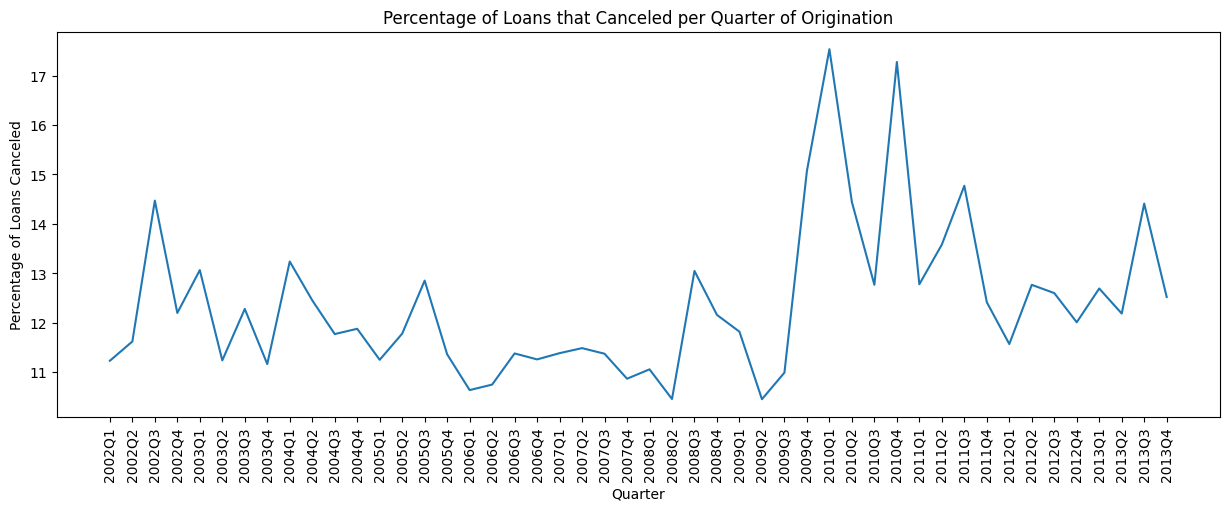

In [ ]:
total_loans_count = res_df.groupby('Quarter').size().reset_index(name='TotalLoanCount')
defaulted_loans_count = res_df[res_df['LoanStatus'] == 'CANCLD'].groupby('Quarter').size().reset_index(name='DefaultedLoanCount')

merged_df = pd.merge(total_loans_count, defaulted_loans_count, on='Quarter', how='left')

merged_df['DefaultedLoanCount'].fillna(0, inplace=True)
merged_df['DefaultedPercentage'] = (merged_df['DefaultedLoanCount'] / merged_df['TotalLoanCount']) * 100

plt.figure(figsize=(15, 5))
sns.lineplot(data=merged_df, x='Quarter', y='DefaultedPercentage')
plt.xticks(rotation=90)
plt.xlabel('Quarter')
plt.ylabel('Percentage of Loans Canceled')
plt.title('Percentage of Loans that Canceled per Quarter of Origination')
plt.show()

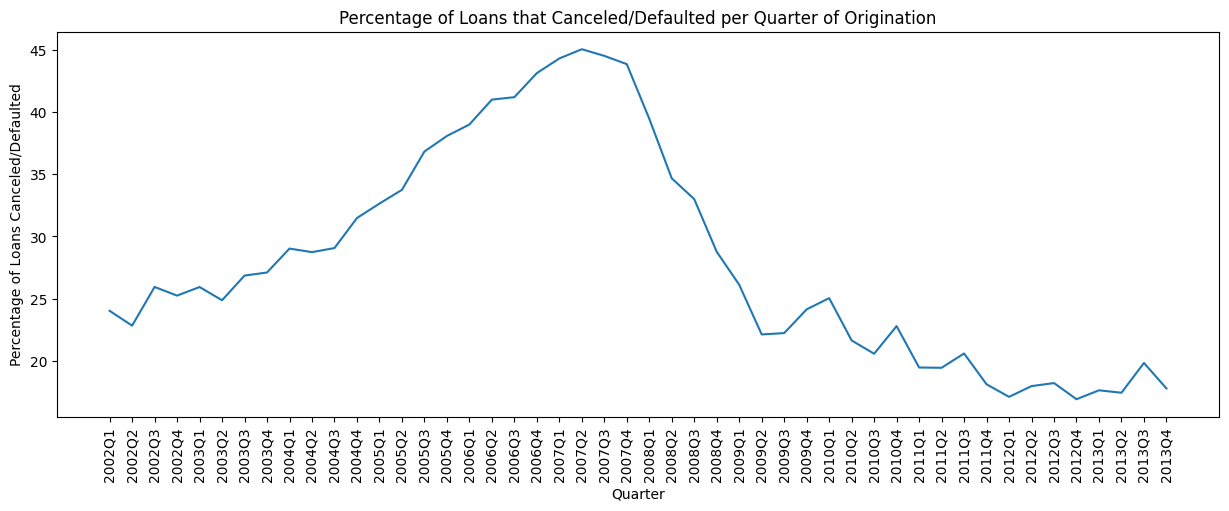

In [ ]:
total_loans_count = res_df.groupby('Quarter').size().reset_index(name='TotalLoanCount')
defaulted_loans_count = res_df[res_df['LoanStatus'].isin(['CANCLD','CHGOFF'])].groupby('Quarter').size().reset_index(name='DefaultedLoanCount')

merged_df = pd.merge(total_loans_count, defaulted_loans_count, on='Quarter', how='left')

merged_df['DefaultedLoanCount'].fillna(0, inplace=True)
merged_df['DefaultedPercentage'] = (merged_df['DefaultedLoanCount'] / merged_df['TotalLoanCount']) * 100

plt.figure(figsize=(15, 5))
sns.lineplot(data=merged_df, x='Quarter', y='DefaultedPercentage')
plt.xticks(rotation=90)
plt.xlabel('Quarter')
plt.ylabel('Percentage of Loans Canceled/Defaulted')
plt.title('Percentage of Loans that Canceled/Defaulted per Quarter of Origination')
plt.show()

# Definitions and Visualizations (Domestic/International)

In [ ]:
historic_domestic = pd.read_csv('/content/2024-Table_2A_Historic_Domestic.csv')
historic_international = pd.read_csv('/content/2024-Table_2B_Historic_International.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/2024-Table_2A_Historic_Domestic.csv'

In [ ]:
historic_international = historic_international.drop(columns=['Scenario Name', 'Date'])

In [ ]:
historic_domestic

In [ ]:
historic = pd.concat([historic_domestic, historic_international], axis=1)
historic.drop(columns=['Scenario Name'])
historic.dropna()
historic = historic.reset_index(drop=True)

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(24, 12))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

enumerated_columns = historic.columns[2:]

# Plot each column in a separate subplot
for i, column in enumerate(enumerated_columns):
    axes[i].plot(historic.index, historic[column])
    axes[i].set_title(column, fontsize=10)
    axes[i].set_xlabel('Quarters since 1999 Q1', fontsize=10)
    axes[i].set_ylabel('Values', fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
historic_crisis = historic.iloc[104:152]
historic_crisis = historic_crisis.reset_index(drop=True)
historic_crisis

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(24, 12))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

enumerated_columns = historic_crisis.columns[2:]

# Plot each column in a separate subplot
for i, column in enumerate(enumerated_columns):
    axes[i].plot(historic_crisis.index, historic_crisis[column])
    axes[i].set_title(column, fontsize=10)
    axes[i].set_xlabel('Quarters since 2002 Q1', fontsize=10)
    axes[i].set_ylabel('Values', fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Cumulative 5y PDs

In [ ]:
FiveYearPD = pd.read_csv('/content/default_percentage.csv')

In [ ]:
FiveYearPD

In [ ]:
# @title DefaultPercentage

from matplotlib import pyplot as plt
FiveYearPD['DefaultPercentage'].plot(kind='line', figsize=(8, 4), title='Five Year Default Percentage')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
merged_df = pd.merge(FiveYearPD, historic, left_on='Quarter', right_on='Date', how='outer')

# Sorting by the Quarter to maintain the chronological order
merged_df = merged_df.sort_values(by='Quarter')
merged_df = merged_df.dropna()
merged_df = merged_df.drop(columns=["Scenario Name", "Date"])
merged_df = merged_df.reset_index(drop=True)
# merged_df = merged_df.iloc[:-20]

In [ ]:
merged_df

# Stationary Testing

Given 100 rows, let's use 80 for training and 20 for validation. The testing will come from the baseline, adverse, and severely adverse scenarios.

In [ ]:
adfuller(merged_df['DefaultPercentage'])
# p-value is 0.12115 > 0.05, not stationary

In [ ]:
def adfuller_test(sales):
    result = adfuller(sales)

    labels = ['ADF test statistics', 'p-value', 'Lags used', 'Number of obs used']

    for value, label in zip(result, labels):
        print('{} : {} '.format(label, value))

    if result[1]<=0.05:
        print('Strong evidence against null hypothesis, reject the null hypothesis and data is stationary')
    else:
        print('Weak evidence against null hypothesis, accept the null hypothesis and data is not stationary')

In [ ]:
adfuller_test(merged_df['DefaultPercentage'])

In [ ]:
# merged_df['PD 1st diff, Shift 1'] = merged_df['DefaultPercentage'] - merged_df['DefaultPercentage'].shift(1)
# adfuller_test(merged_df['PD 1st diff, Shift 1'].dropna())

In [ ]:
# merged_df['PD 1st diff, Shift 2'] = merged_df['DefaultPercentage'] - merged_df['DefaultPercentage'].shift(2)
# adfuller_test(merged_df['PD 1st diff, Shift 2'].dropna())

In [ ]:
# merged_df['PD 1st diff, Shift 3'] = merged_df['DefaultPercentage'] - merged_df['DefaultPercentage'].shift(3)
# adfuller_test(merged_df['PD 1st diff, Shift 3'].dropna())

In [ ]:
merged_df['PD 1st diff, Shift 4'] = merged_df['DefaultPercentage'] - merged_df['DefaultPercentage'].shift(4)
adfuller_test(merged_df['PD 1st diff, Shift 4'].dropna())

In [ ]:
merged_df['PD 1st diff, Shift 4'].plot()

In [ ]:
merged_df['PD 2nd diff, Shift 4->1'] = merged_df['PD 1st diff, Shift 4'] - merged_df['PD 1st diff, Shift 4'].shift(1)
adfuller_test(merged_df['PD 2nd diff, Shift 4->1'].dropna())

In [ ]:
merged_df['PD 2nd diff, Shift 4->1'].plot()

In [ ]:
merged_df

In [ ]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(merged_df['PD 1st diff, Shift 4'].iloc[4:], lags=35, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(merged_df['PD 1st diff, Shift 4'].iloc[4:], lags=35, ax=ax2)

In [ ]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(merged_df['PD 2nd diff, Shift 4->1'].iloc[5:], lags=35, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(merged_df['PD 2nd diff, Shift 4->1'].iloc[5:], lags=35, ax=ax2)

In [ ]:
merged_df.columns

In [ ]:
merged_df['CPI inflation rate'].plot()

In [ ]:
selected_columns = merged_df.iloc[:, 2:-3]

# Calculate the correlation with 'DefaultPercentage'
correlations = selected_columns.corrwith(merged_df['DefaultPercentage'])

with pd.option_context('display.max_rows', None):
  print(correlations)

In [ ]:
model = sm.tsa.statespace.SARIMAX(merged_df['DefaultPercentage'], order=(2,1,3), seasonal_order=(2,1,3,4), exog=merged_df[['Developing Asia real GDP growth','Prime rate', '5-year Treasury yield','U.K. bilateral dollar exchange rate (USD/pound)']])
results = model.fit()

In [ ]:
merged_df['forecast_SARIMAX'] = results.predict(start=81, end=99, dynamic=True)

In [ ]:
merged_df[['DefaultPercentage','forecast_SARIMAX']].plot(figsize=(12,10))

In [ ]:
model = ARIMA(merged_df['DefaultPercentage'], order=(2,1,3), exog=merged_df[['Developing Asia real GDP growth','Prime rate', '5-year Treasury yield','U.K. bilateral dollar exchange rate (USD/pound)']])
results = model.fit()

In [ ]:
merged_df['forecast_SARIMAX'] = results.predict(start=81, end=99, dynamic=True)

In [ ]:
merged_df[['DefaultPercentage','forecast_SARIMAX']].plot(figsize=(12,10))